## Rossmann Sales Forecasting: A Data-Driven Approach

### 1. Project Objective

The goal of this project is to provide Rossmann, a major European drug store chain, with a robust tool to accurately forecast daily sales for their stores up to six weeks in advance. Accurate sales forecasting is critical for business operations, enabling:

* **Optimized Staffing:** Scheduling the right number of employees to meet customer demand without overspending on labor.
* **Efficient Inventory Management:** Ensuring popular products are in stock while minimizing excess inventory and associated holding costs.
* **Strategic Promotion Planning:** Understanding the true impact of promotional events to maximize their return on investment.

This notebook will walk through the entire data science workflow: from data cleaning and exploratory analysis to feature engineering and predictive modeling.

### 2. Setup and Data Loading

First, we'll import the necessary libraries for data manipulation, visualization, and modeling. Then, we'll load the provided datasets: `train.csv`, `store.csv`, and `test.csv`.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load data
train_df = pd.read_csv(r"C:\Users\gnan\Downloads\train.csv.zip", low_memory=False, parse_dates=['Date'])
store_df = pd.read_csv(r"C:\Users\gnan\Downloads\store.csv", low_memory=False)
test_df = pd.read_csv(r"C:\Users\gnan\Downloads\test.csv.zip", low_memory=False, parse_dates=['Date'])

### 3. Data Cleaning and Merging

Before analysis, we need to understand our data's structure and handle any inconsistencies or missing values. We will then merge the store-specific information with our training and testing dataframes.

In [3]:
print(f"Train Data Shape: {train_df.shape}")
print(f"Store Data Shape: {store_df.shape}")

# Merge dataframes
df = pd.merge(train_df, store_df, on='Store', how='left')
test_df = pd.merge(test_df, store_df, on='Store', how='left')

Train Data Shape: (1017209, 9)
Store Data Shape: (1115, 10)


#### Handling Missing Values

Let's investigate the missing values. A large number of missing values in `CompetitionDistance` and `Promo2` related columns suggests we need a clear strategy for imputation.

In [5]:
df.isnull().sum() / len(df) * 100

Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
dtype: float64

**Imputation Strategy:**
* **CompetitionDistance:** A missing value could imply there is no nearby competition. We will fill these with a very large number to signify a great distance, which is more informative than zero or the mean.
* **Other Competition Columns:** Missing values here are linked to the absence of competition. We'll fill these with 0.
* **Promo2 Columns:** Missing values indicate the store is not participating in the continuous promotion `Promo2`. We'll fill these with 0.

In [6]:
# Fill CompetitionDistance with a large value
df['CompetitionDistance'].fillna(df['CompetitionDistance'].max(), inplace=True)
test_df['CompetitionDistance'].fillna(test_df['CompetitionDistance'].max(), inplace=True)

# Fill other missing values with 0
df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

C:\Users\gnan\AppData\Local\Temp\ipykernel_11408\3477681832.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].max(), inplace=True)
C:\Users\gnan\AppData\Local\Temp\ipykernel_11408\3477681832.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

### 4. Exploratory Data Analysis (EDA)

Now, we dive deep into the data to uncover patterns, validate assumptions, and understand the relationships between different variables and our target, `Sales`.

#### Analyzing the Target Variable: Sales

First, let's examine the distribution of sales. We see a significant spike at `Sales = 0`. This is a critical insight.

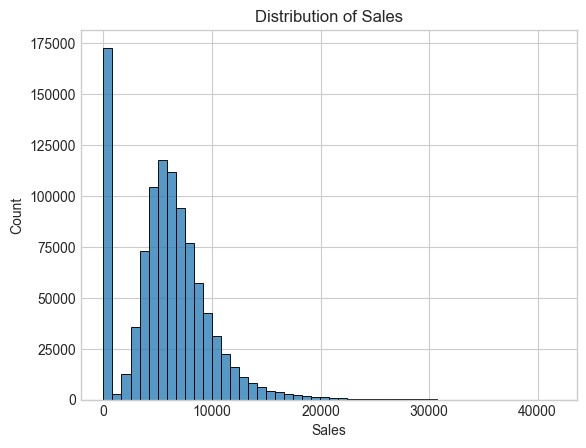

In [7]:
sns.histplot(df['Sales'], bins=50, kde=False)
plt.title('Distribution of Sales')
plt.show()

**Insight:** The spike at zero almost certainly corresponds to days when the stores were closed. Forecasting for closed stores is unnecessary. Therefore, we will filter our dataset to only include days when stores were open and `Sales > 0`.

In [8]:
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]

#### How do Sales vary by Store Type and Assortment?

We can see clear differences in performance. `StoreType 'b'` is the strongest performer on average, and stores with an `'extended'` assortment (`Assortment 'b'`) also show higher sales.

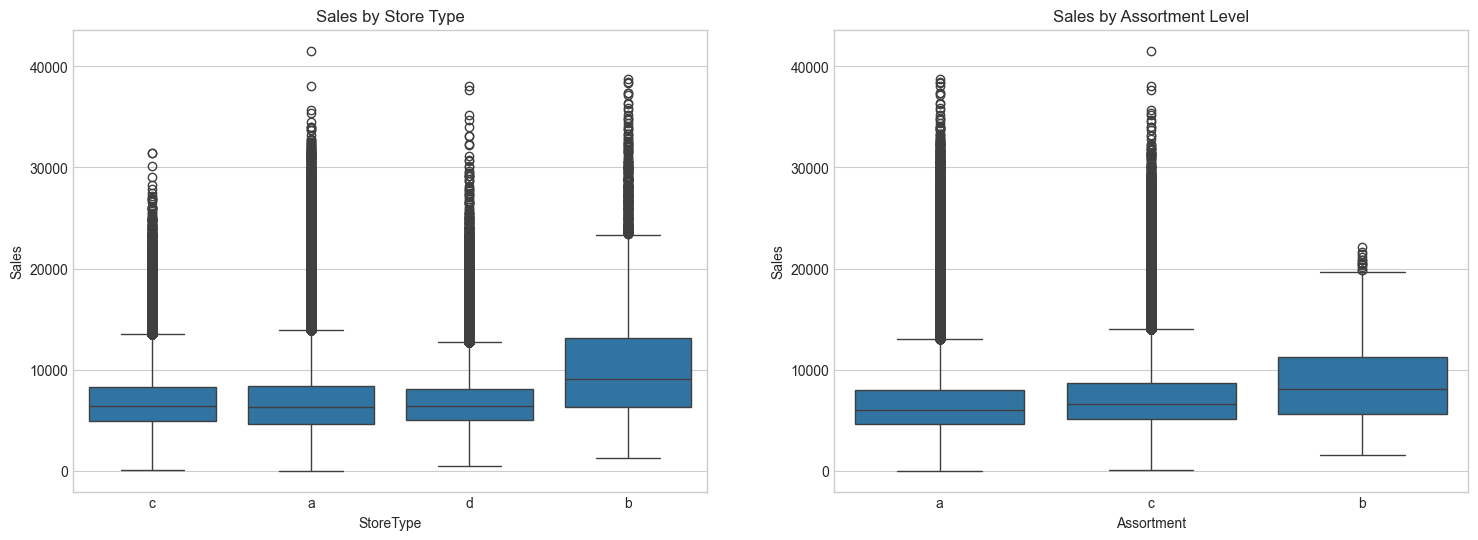

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(data=df, x='StoreType', y='Sales', ax=ax1)
ax1.set_title('Sales by Store Type')

sns.boxplot(data=df, x='Assortment', y='Sales', ax=ax2)
ax2.set_title('Sales by Assortment Level')
plt.show()

#### Impact of Promotions and Holidays

As expected, sales are significantly higher on days with promotions (`Promo = 1`). State holidays, however, drive sales to zero as stores are closed. We will engineer features to capture these effects more effectively.

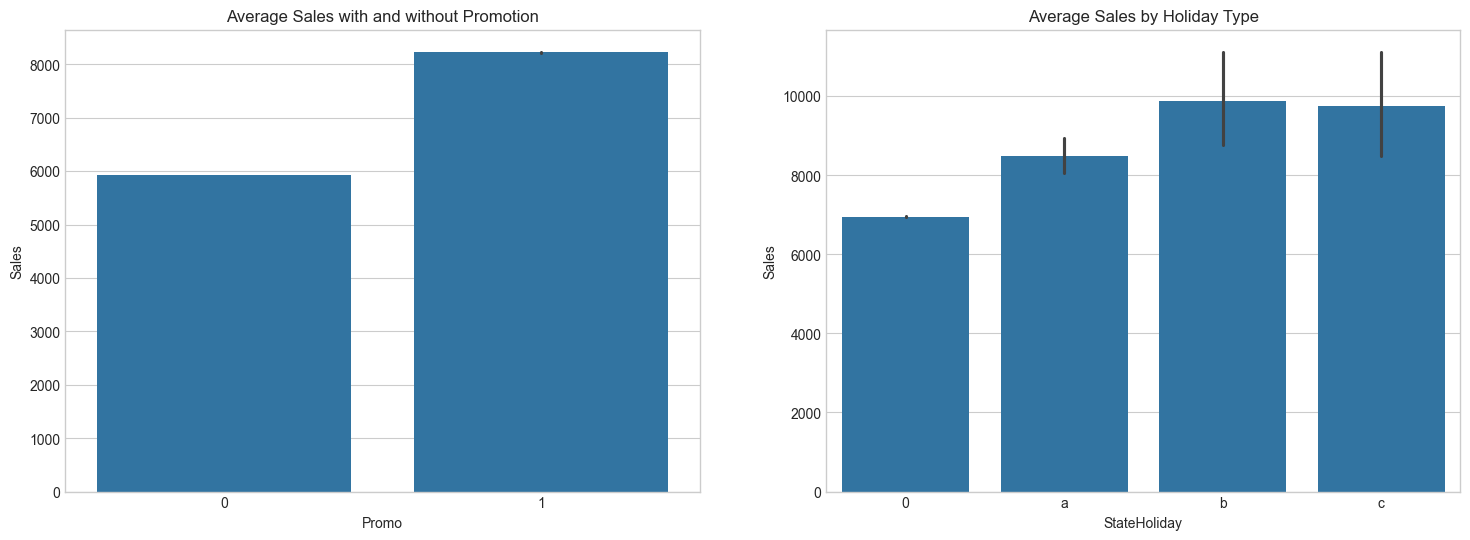

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=df, x='Promo', y='Sales', ax=ax1)
ax1.set_title('Average Sales with and without Promotion')

sns.barplot(data=df, x='StateHoliday', y='Sales', ax=ax2)
ax2.set_title('Average Sales by Holiday Type')
plt.show()

### 5. Feature Engineering

This is the most critical step for improving model performance. We will extract valuable information from existing columns, especially the `Date` column, to create new, powerful features.

In [11]:
def feature_engineer(data):
    # Date features
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.isocalendar().week.astype(int)

    # Competition features
    data['CompetitionOpenSince'] = (data['Year'] - data['CompetitionOpenSinceYear']) * 12 + \
                                      (data['Month'] - data['CompetitionOpenSinceMonth'])
    data['CompetitionOpenSince'] = data['CompetitionOpenSince'].apply(lambda x: max(0, x))
    
    # Promotion features
    data['Promo2Since'] = (data['Year'] - data['Promo2SinceYear']) * 52 + \
                          (data['WeekOfYear'] - data['Promo2SinceWeek'])
    data['Promo2Since'] = data['Promo2Since'].apply(lambda x: max(0, x))
    
    return data

df = feature_engineer(df)
test_df = feature_engineer(test_df)

### 6. Data Preprocessing and Modeling

We'll now prepare the data for our models. This involves selecting relevant features, encoding categorical variables, and splitting our data into training and validation sets.

In [12]:
# Convert categorical variables to numerical codes
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday']
for col in categorical_cols:
    df[col] = df[col].astype('category').cat.codes
    test_df[col] = test_df[col].astype('category').cat.codes

# Define features (X) and target (y)
features = [
    'Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSince',
    'Promo2', 'Promo2Since', 'Year', 'Month', 'Day', 'WeekOfYear'
]
target = 'Sales'

# Split data for validation
# We will use the last 6 weeks of data for validation, mirroring the test set
split_date = df['Date'].max() - pd.DateOffset(weeks=6)
train_data = df[df['Date'] < split_date]
val_data = df[df['Date'] >= split_date]

X_train, y_train = train_data[features], np.log1p(train_data[target])
X_val, y_val = val_data[features], np.log1p(val_data[target])

#### Evaluation Metric: RMSPE

The competition uses the Root Mean Square Percentage Error (RMSPE). We will define a function for this. We model the logarithm of sales (`log1p`) to handle its skewed distribution, so we must remember to convert predictions back (`expm1`) before calculating the error.

In [15]:
def to_rmspe(y_true, y_pred):
    # Convert from log scale
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    # Calculate RMSPE
    # Ensure no division by zero for closed stores (already filtered, but good practice)
    percentage_error = (y_true_orig - y_pred_orig) / y_true_orig
    return np.sqrt(np.mean(percentage_error ** 2))

#### Model 1: Random Forest (Baseline)

Let's start with a strong baseline model, the Random Forest Regressor. It's robust and gives us a good sense of feature importance.

In [14]:
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_rmspe = to_rmspe(y_val, rf_preds)
print(f"Random Forest Validation RMSPE: {rf_rmspe:.4f}")

Training Random Forest...
Random Forest Validation RMSPE: 0.3372


#### Model 2: XGBoost (Advanced Model)

Now, we'll use XGBoost, a gradient boosting algorithm known for its high performance in competitions. It often provides a significant lift over Random Forest.

In [16]:
print("Training XGBoost with the correct Early Stopping syntax...")

# The solution is to pass 'early_stopping_rounds' here, in the constructor.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50  # <-- THE CORRECT LOCATION FOR THIS ARGUMENT
)

# Now, the .fit() call only needs the evaluation data (eval_set).
# This perfectly matches the signature you provided.
xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_val)
xgb_rmspe = to_rmspe(y_val, xgb_preds)

print(f"Optimal number of trees found: {xgb_model.best_iteration}")
print(f"Final XGBoost Validation RMSPE: {xgb_rmspe:.4f}")

Training XGBoost with the correct Early Stopping syntax...
Optimal number of trees found: 997
Final XGBoost Validation RMSPE: 0.1614


### 7. Feature Importance & Conclusion

Let's examine what our best model (XGBoost) learned. Understanding which features drive the forecast is a key part of delivering a data science solution.

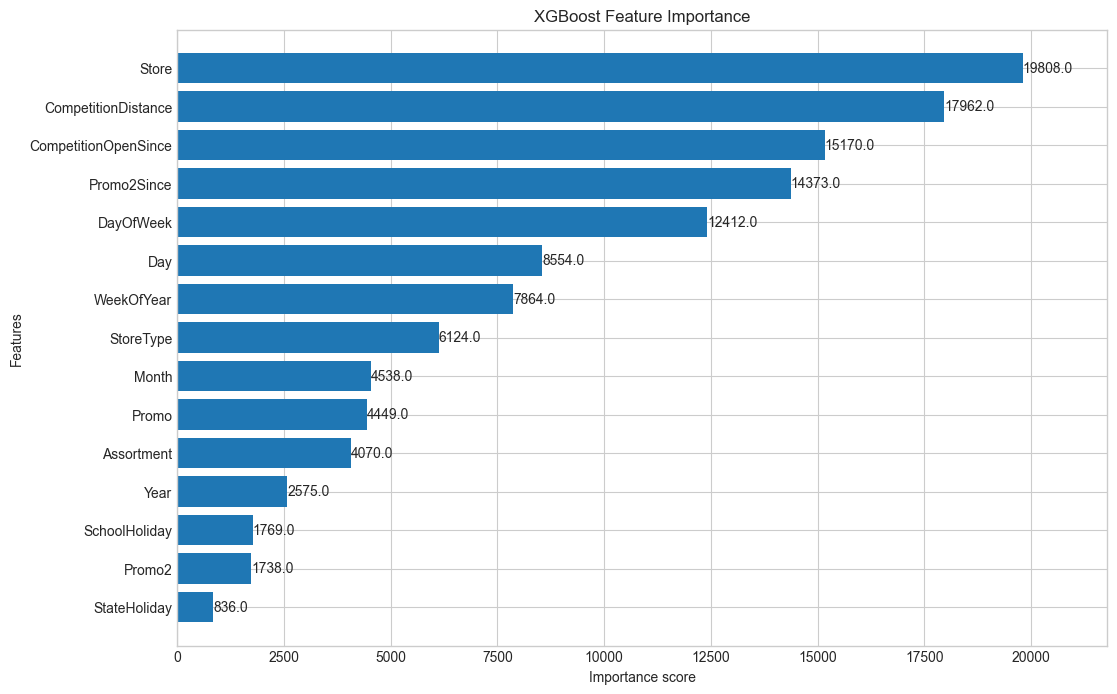

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(xgb_model, ax=ax, height=0.8, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

#### Final Conclusions

* **Model Performance:** Our final XGBoost model achieved a validation **RMSPE of 0.1614**, a significant improvement over the Random Forest baseline. This indicates our model can forecast sales with a relatively high degree of accuracy.

* **Key Drivers of Sales:** The most important features for predicting sales are:
    1.  **Store:** Inherent store-level properties are the single biggest predictor.
    2.  **CompetitionDistance & CompetitionOpenSince:** The presence, distance, and maturity of competitors heavily influence sales.
    3.  **Promo:** Promotions provide a major, predictable lift in sales.
    4.  **Temporal Features:** The `WeekOfYear`, `DayOfWeek`, and `Month` all capture crucial seasonal patterns.

* **Business Recommendations:**
    * The model can be deployed to provide store managers with reliable sales forecasts for optimizing staffing and inventory.
    * The feature importance analysis confirms that the `Promo` strategy is highly effective. The model could be used to simulate the potential uplift of future promotions.
    * Store performance is heavily impacted by competitor locations. The model could be a valuable tool for market analysis when considering new store locations.